In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pd.read_csv('../data/jan_data.csv')
df['time'] = pd.to_datetime(df['time'])

df.iloc[1800]['dollar_open_interest_close']

2192294834.146

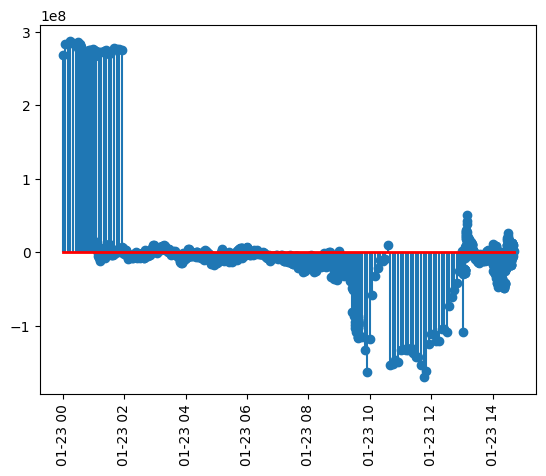

In [113]:

df['diff'] = df['dollar_open_interest_close'].diff(periods=30)
# df.loc[df['diff'] >= df['diff'].quantile(0.99)]
df_jan2324 = df.loc[(df['time']>'2024-01-10') & (df['time']<'2024-01-24')]
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()
